In [ ]:
import geopandas as gpd
import pandas as pd
import requests
import os

# Create cache directory
CACHE_DIR = "../data_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

In [ ]:
# Fetch or cache function
def fetch_or_cache(url, local_path):
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(r.content)
        print(f"Fetched {url}")
    except Exception as e:
        print(f"Warning: could not fetch {url}, using cached copy. ({e})")
        if not os.path.exists(local_path):
            raise FileNotFoundError(f"No cached copy for {url}")

# Example test: saline wetlands GeoJSON
SALINE_WETLAND_URL = "https://data-cdfw.opendata.arcgis.com/api/download/v1/items/86f3f1edf91d44be9a8f237a0afde994/geojson?layers=0"
wetlands_path = os.path.join(CACHE_DIR, "saline_wetlands.geojson")
fetch_or_cache(SALINE_WETLAND_URL, wetlands_path)


Fetched https://data-cdfw.opendata.arcgis.com/api/download/v1/items/86f3f1edf91d44be9a8f237a0afde994/geojson?layers=0


In [ ]:
# Read wetlands polygons and inspect
wetlands = gpd.read_file(wetlands_path).to_crs("EPSG:4326")
wetlands.head(), wetlands.crs

(   OBJECTID  Hex_ID  SaltWetld SaltWetVeg SaltWetVeg_datasets EstuaryTidal  \
 0        63   37647          1          Y           ds2632;              N   
 1        84    6865          1          Y           ds2630;              Y   
 2       101   22390          1          N                                Y   
 3       111   33436          1          Y           ds1327;              N   
 4       174   33247          1          Y           ds1327;              N   
 
   EstuaryTidal_datasets Eco_Sect                   Eco_Name Jepson_Eco  \
 0                           262A       Great Valley (south)       SnJV   
 1             ds2793;       263A  Northern California Coast        NCo   
 2             ds2793;       262A       Great Valley (north)        ScV   
 3                           261A   Central California Coast        CCo   
 4                           261A   Central California Coast        CCo   
 
        County   Shape__Area  Shape__Length  \
 0       KINGS  9.969068e

In [ ]:
# Read saline lake shapefile (manual zip download required)
# Download from: https://www.sciencebase.gov/catalog/item/667f1a25d34e2cb7853eaf4f

lake_zip_path = os.path.join(CACHE_DIR, "SalineLakeEcosy.zip")
lakes_dir = os.path.join(CACHE_DIR, "SalineLakeBnd")
lakes_path = os.path.join(lakes_dir, "SalineLakeBnd.shp")

if not os.path.exists(lakes_dir):
    if not os.path.exists(lake_zip_path):
        raise FileNotFoundError(
            "Please manually download SalineLakeEcosy.zip to data_cache/ and rerun"
        )
    print("Extracting Saline Lake zip...")
    import zipfile
    with zipfile.ZipFile(lake_zip_path, 'r') as zip_ref:
        zip_ref.extractall(CACHE_DIR)
else:
    print("Using existing extracted SalineLakeBnd directory")

# Read shapefile
lakes = gpd.read_file(lakes_path).to_crs("EPSG:4326")
lakes.head(), lakes.crs


Using existing extracted SalineLakeBnd directory


(     Shape_Leng    Shape_Area          Name State  \
 0  87637.729242  2.730233e+08  Malheur Lake    OR   
 1  40479.063776  1.122221e+08   Harney Lake    OR   
 2  62845.220623  1.661274e+08   Albert Lake    OR   
 3  51541.185017  1.252078e+08   Summer Lake    OR   
 4  27637.526963  4.044161e+07   Silver Lake    OR   
 
                                             geometry  
 0  POLYGON ((-118.83679 43.37588, -118.79849 43.3...  
 1  POLYGON ((-119.10235 43.27899, -119.07107 43.2...  
 2  POLYGON ((-120.22907 42.73748, -120.20672 42.7...  
 3  POLYGON ((-120.7181 42.86618, -120.71053 42.84...  
 4  POLYGON ((-120.91214 43.12899, -120.88598 43.1...  ,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [17]:
url = (
    "https://services8.arcgis.com/JFYbogndXme7ddg8/arcgis/rest/services/"
    "CA_Nature_Terrestrial_and_Marine__AGOL__WebMer_/FeatureServer/0/query"
    "?where=1=1&outFields=*&outSR=4326&f=json"
)

coastal = gpd.read_file(url)

/Users/chloecheng/opt/anaconda3/envs/safe2swim/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


/var/folders/mq/4dcyk52x1gv1330mgtd8_ghh0000gn/T/ipykernel_4575/258580155.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  marine_buffered = marine.unary_union.buffer(COASTAL_BUFFER_DEGREES)
Matplotlib is building the font cache; this may take a moment.


<Axes: >

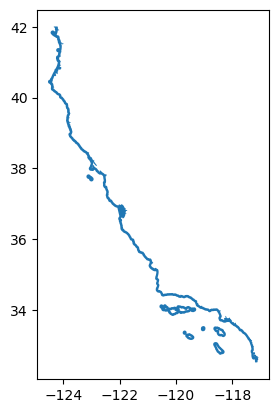

In [ ]:
# Fetch and read coastal polygons

# Filter only marine polygons using TerrMar == "Marine"
marine = coastal[coastal["TerrMar"].str.lower() == "marine"]

# Apply buffer
COASTAL_BUFFER_DEGREES = 0.01  # adjustable
marine_union = marine.geometry.union_all()
marine_buffered = marine_union.buffer(COASTAL_BUFFER_DEGREES)

# Wrap in GeoDataFrame for inspection
marine_buffered_gdf = gpd.GeoDataFrame(geometry=[marine_buffered], crs="EPSG:4326")
marine_buffered_gdf.plot()


In [ ]:
# Load sample site data from CKAN

def fetch_ckan_all(resource_id, fields=None):
    base_url = "https://data.ca.gov/api/3/action/datastore_search"
    offset = 0
    limit = 50000
    dfs = []
    while True:
        params = {"resource_id": resource_id, "limit": limit, "offset": offset}
        if fields:
            params["fields"] = fields
        r = requests.get(base_url, params=params)
        r.raise_for_status()
        result = r.json()["result"]
        records = result["records"]
        dfs.append(pd.DataFrame(records))
        offset += limit
        if offset >= result["total"]:
            break
    return pd.concat(dfs, ignore_index=True)

resource_ids = [
    "1d333989-559a-433f-b93f-bb43d21da2b9",
    "04d98c22-5523-4cc1-86e7-3a6abf40bb60",
    "15a63495-8d9f-4a49-b43a-3092ef3106b9"
]
sites = pd.concat([fetch_ckan_all(rid, "StationCode,TargetLatitude,TargetLongitude") 
                   for rid in resource_ids], ignore_index=True)
sites = sites.drop_duplicates()
print("Unique stations:", sites["StationCode"].nunique())

Unique stations: 5968


In [ ]:
# Unique sites with geometry
gdf_sites = gpd.GeoDataFrame(
    sites,
    geometry=gpd.points_from_xy(sites.TargetLongitude, sites.TargetLatitude),
    crs="EPSG:4326"
)
gdf_sites.head()


,StationCode,TargetLatitude,TargetLongitude,geometry
0,0,33.6293,-117.960,POINT (-117.96 33.6293)
2552,12N,33.6467,-117.989,POINT (-117.989 33.6467)
4588,12S,33.6096,-117.931,POINT (-117.931 33.6096)
5502,15N,33.6521,-117.998,POINT (-117.998 33.6521)
8095,15S,33.6563,-117.924,POINT (-117.924 33.6563)


In [ ]:
# Combine all saltwater polygons

# Combine into one GeoDataFrame
saltwater_polygons = gpd.GeoDataFrame(
    pd.concat([wetlands, lakes, marine_buffered_gdf], ignore_index=True),
    crs="EPSG:4326"
)

# Union all geometries
saltwater_union = saltwater_polygons.geometry.union_all()

# Quick check
print("Saltwater union geometry type:", saltwater_union.geom_type)


Saltwater union geometry type: MultiPolygon


In [36]:
# Ensure valid coordinates
gdf_sites = gdf_sites.dropna(subset=["geometry"])

# Classify each site: True = saltwater
gdf_sites["saltwater"] = gdf_sites.geometry.within(saltwater_union)

print("Total sites classified:", len(gdf_sites))
print("Saltwater sites:", gdf_sites["saltwater"].sum())
print("Freshwater sites:", (~gdf_sites["saltwater"]).sum())
gdf_sites.head()


Total sites classified: 5976
Saltwater sites: 2513
Freshwater sites: 3463


,StationCode,TargetLatitude,TargetLongitude,geometry,saltwater
0,0,33.6293,-117.960,POINT (-117.96 33.6293),True
2552,12N,33.6467,-117.989,POINT (-117.989 33.6467),True
4588,12S,33.6096,-117.931,POINT (-117.931 33.6096),True
5502,15N,33.6521,-117.998,POINT (-117.998 33.6521),True
8095,15S,33.6563,-117.924,POINT (-117.924 33.6563),False


In [ ]:
# Path for output CSV
output_path = "data/site_saltwater_flags.csv"

# Ensure output directory exists
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Save only station code and classification flag
gdf_sites[["StationCode", "saltwater"]].to_csv(output_path, index=False)

print(f"Classification saved to {output_path}")

Classification saved to data/site_saltwater_flags.csv
